In [1]:
import numpy as np
import pandas as pd
import torch
from pathlib import Path
from collections import defaultdict
from itertools import combinations
from tqdm.notebook import tqdm_notebook
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [3]:
p_data = Path("D:/Datas/kaggle_movie/")

In [3]:
df = pd.read_csv(p_data / "ratings_small.csv")

movie를 node로 한 관계

In [4]:
movie_nodes_meta = defaultdict(dict)
movie_nodes = []
unique_uid = np.unique(df.iloc[:, 0].values)
for uid in tqdm_notebook(unique_uid):
    datas = df.loc[df["userId"] == uid, :].values[:, :-1]
    movies = datas[:, 1].astype(np.int)
    nodes = list(combinations(movies, 2))
    movie_nodes.extend(nodes)
    meta = list(zip(*[movies, list(map(lambda x: (int(x[0]), x[1]), datas[:, (0, 2)].tolist()))]))
    for node, x in meta:
        if movie_nodes_meta[node].get("ratings") is None:
            movie_nodes_meta[node]["ratings"] = list()
            movie_nodes_meta[node]["count"] = 0
        movie_nodes_meta[node]["ratings"].append(x)
        movie_nodes_meta[node]["count"] += 1
        
df_medge = pd.DataFrame(movie_nodes)
df_medge.to_csv(p_data / "movie_edges.csv", index=False)
with (p_data / "movie_nodes_meta.pickle").open("wb") as file:
    pickle.dump(movie_nodes_meta, file)

user를 node로 한 관계

In [24]:
user_nodes_meta = defaultdict(dict)
user_nodes = []
unique_mid = np.unique(df.iloc[:, 1].values)
for mid in tqdm_notebook(unique_mid):
    datas = df.loc[df["movieId"] == mid, :].values[:, :-1]
    users = datas[:, 0].astype(np.int)
    nodes = list(combinations(users, 2))
    user_nodes.extend(nodes)
    meta = list(zip(*[users, list(map(lambda x: (int(x[0]), x[1]), datas[:, (1, 2)].tolist()))]))
    for node, x in meta:
        if user_nodes_meta[node].get("ratings") is None:
            user_nodes_meta[node]["ratings"] = list()
            user_nodes_meta[node]["count"] = 0
        user_nodes_meta[node]["ratings"].append(x)
        user_nodes_meta[node]["count"] += 1
        
df_uedge = pd.DataFrame(user_nodes)
df_uedge.to_csv(p_data / "user_edges.csv", index=False)
with (p_data / "user_nodes_meta.pickle").open("wb") as file:
    pickle.dump(user_nodes_meta, file)

movies_meta.csv 오류 고치기

In [30]:
import csv
csv.writer((p_data / "movies_metadata_temp.tsv").open("w+", encoding="utf-8"), delimiter="\t").writerows(
    csv.reader((p_data / "movies_metadata.csv").open("r", encoding="utf-8")))

with (p_data / "movies_metadata_temp.tsv").open("r", encoding="utf-8") as file:
    datas = file.readlines()
    
new_datas = {}
cols = datas[0].rstrip().split("\t")
n_cols = len(cols)
error_ids = []
for i, line in tqdm_notebook(enumerate(datas), total=len(datas)):
    line = line.rstrip()
    if not line:
        continue
    else:
        if len(line.split("\t")) != n_cols:
            error_ids.append(len(new_datas))        
        new_datas[len(new_datas)] = line

merge_ids = {}
temp = []
for idx, cur_id in enumerate(error_ids):
    if not temp:
        start_id = cur_id
        merge_ids[start_id] = 0
        temp.append(cur_id)
        continue
    
    if cur_id - 1 == temp[-1]:
        temp.append(cur_id)
    if idx+1 == len(error_ids):
        merge_ids[start_id] = temp
    elif (error_ids[idx+1] - cur_id) >= 2:
        merge_ids[start_id] = temp
        temp = []
        
for start_id, mids in merge_ids.items():
    line = ""
    for idx in mids:
        l = new_datas.pop(idx)
        line += l
    new_datas[start_id] = line
    
new_datas = [x.split("\t") for x in list(zip(*sorted(new_datas.items(), key=lambda x: x[0])))[1]]

df_meta = pd.DataFrame(new_datas[1:], columns=new_datas[0])
df_meta.to_csv((p_data / "movies_metadata.tsv"), sep="\t", index=False)

In [ ]:
with (p_data / "movie_nodes_meta.pickle").open("wb") as file:
    movie_nodes_meta = pickle.load(file)

with (p_data / "user_nodes_meta.pickle").open("wb") as file:
    user_nodes_meta = pickle.load(file)

In [689]:
df_meta = pd.read_csv((p_data / "movies_metadata.tsv"), sep="\t")
df_meta.drop(index=df_meta[df_meta["imdb_id"].isna()].index, inplace=True)
df_meta["imdbId"] = df_meta["imdb_id"].str.slice(start=3).astype(np.int64)

f_change = lambda s: "|".join([tuple(dict(x).values())[1] for x in eval(s)])
df_meta["genres"] = df_meta["genres"].apply(f_change)
df_meta["genres_main"] = df_meta["genres"].str.split("|", 1, expand=True)[0].values

df_meta["spoken_languages"] = df_meta["spoken_languages"].apply(f_change)

df_meta["production_countries"] = df_meta["production_countries"].str.strip('"').str.replace("\"\"Cote D'Ivoire\"\"", "'Cote D Ivoire'").str.replace("\"\"Lao People's Democratic Republic\"\"", "'Lao People s Democratic Republic'")
df_meta["production_countries"] = df_meta["production_countries"].apply(f_change)
df_meta["production_countries_main"] = df_meta["production_countries"].str.split("|", 1, expand=True)[0].values

adult ratio

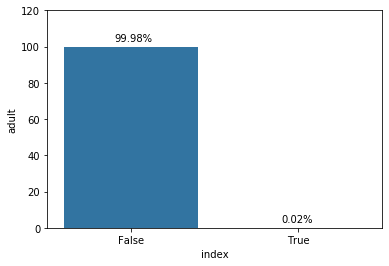

In [690]:
df_plot = df_meta["adult"].value_counts(normalize=True).reset_index()
df_plot["adult"] = df_plot["adult"] * 100
g = sns.barplot(x="index", y="adult", data=df_plot)
g.set_ylim(0,120)

for p in g.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() + 0.3
    txt_h = p.get_height() + 3
    g.text(txt_x, txt_h, txt)

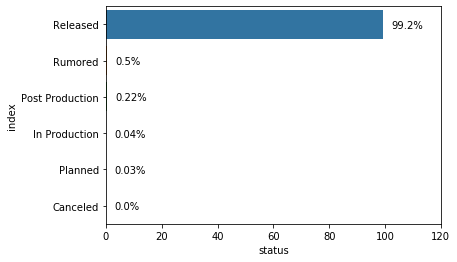

In [691]:
df_plot = df_meta["status"].value_counts(normalize=True).reset_index()
df_plot["status"] = df_plot["status"] * 100
g = sns.barplot(x="status", y="index", data=df_plot)
g.set_xlim(0,120)
for p in g.patches:
    txt = str(p.get_width().round(2)) + '%'
    txt_y = p.get_y() + 0.5
    txt_w = p.get_width() + 3
    g.text(txt_w, txt_y, txt)

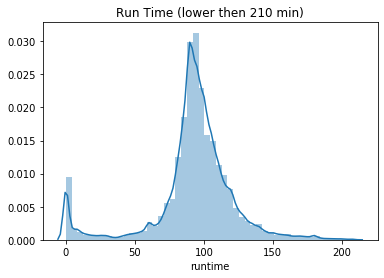

In [692]:
sns.distplot(df_meta.loc[df_meta["runtime"] < 210, "runtime"])
plt.title("Run Time (lower then 210 min)")
plt.show()

vote_average distribution & vote_counts distribution by main genres

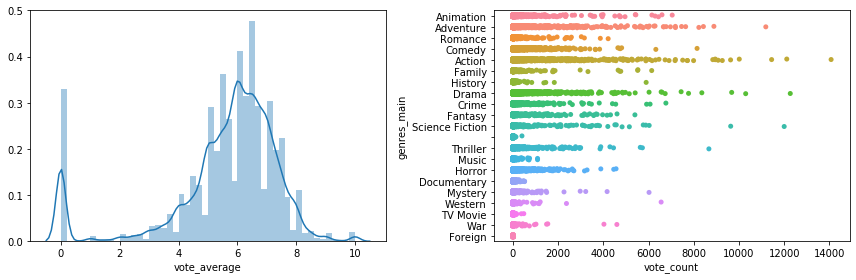

In [693]:
df_plot = df_meta.loc[:, ("vote_count", "vote_average", "genres_main")]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.distplot(df_plot["vote_average"], ax=axes[0])
sns.stripplot(x="vote_count", y="genres_main", data=df_plot, ax=axes[1])
plt.tight_layout()
plt.show()

popularity

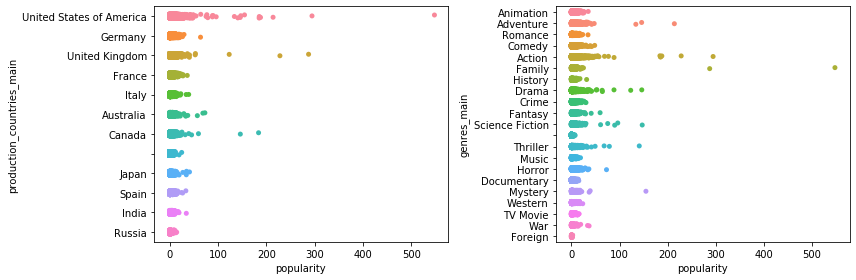

In [694]:
df_plot = df_meta.loc[:, ("popularity", "production_countries_main", "genres_main")]
idx = df_plot["production_countries_main"].value_counts() > 500

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.stripplot(x="popularity", y="production_countries_main", 
              data=df_plot.loc[df_plot["production_countries_main"].isin(idx.index[idx]), :], ax=axes[0])
sns.stripplot(x="popularity", y="genres_main", data=df_plot, ax=axes[1])
plt.tight_layout()
plt.show()

movie ages

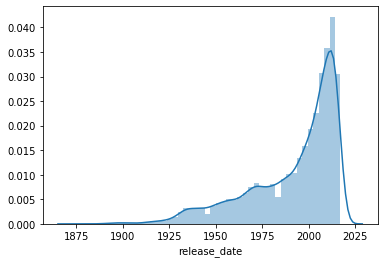

In [695]:
df_plot = df_meta["release_date"].str.slice(0, 4)
sns.distplot(df_plot[~df_plot.isna()].astype(int))

In [696]:
def movie_age(x):
    if pd.isnull(x):
        return None
    year = int(x)
    if (year < 1900): return "-1900"
    elif (1900 <= year <= 1975): return "1900-1975"
    elif (1976 <= year <= 1995): return "1976-1995"
    elif (1996 <= year <= 2003): return "1996-2003"
    elif (2004 <= year <= 2009): return "2004-2009"
    elif (2010 <= year): return "2010-"
    else: return 0

In [697]:
df_meta["release_cate"] = df_meta["release_date"].str.slice(0, 4).apply(movie_age)

Max: Popular Movie: 
         title                             genres  vote_average
30698  Minions  Family|Animation|Adventure|Comedy           6.4


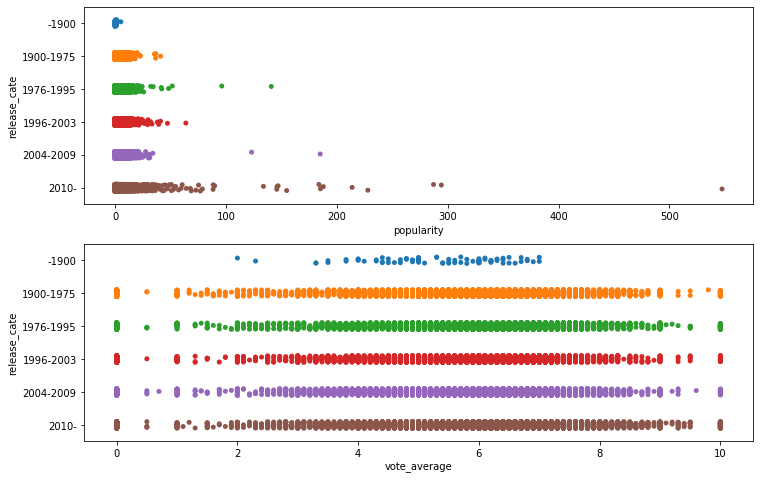

In [698]:
df_plot = df_meta.loc[:, ("popularity", "vote_average", "release_cate")].sort_values("release_cate")

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
sns.stripplot(x="popularity", y="release_cate", data=df_plot, ax=axes[0])
sns.stripplot(x="vote_average", y="release_cate", data=df_plot, ax=axes[1])

print("Max: Popular Movie: ")
print(df_meta.loc[df_meta["popularity"] == df_plot["popularity"].max(), ("title", "genres", "vote_average")])
plt.show()

In [699]:
cols = ['adult', 'genres', 'overview', 'popularity', 'production_countries',
        'revenue', 'runtime', 'spoken_languages', 'status' , 'title', 'vote_average', 
        'vote_count', 'imdbId', 'release_cate']
df_link = pd.read_csv(p_data / "links_small.csv")

In [703]:
df_meta2 = pd.merge(df_meta.loc[:, cols], df_link.iloc[:, :-1], on="imdbId")
cols2 = ['movieId', 'imdbId', 'title', 'release_cate', 'genres', 'runtime', 'production_countries', 
        'spoken_languages', 'status', 'adult', 'popularity', 'vote_average', 'vote_count', 'revenue', 
         'overview']
df_meta2 = df_meta2.loc[:, cols2]
df_meta2.head()

,movieId,imdbId,title,release_cate,genres,runtime,production_countries,spoken_languages,status,adult,popularity,vote_average,vote_count,revenue,overview
0,1,114709,Toy Story,1976-1995,Animation|Comedy|Family,81.0,United States of America,English,Released,False,21.946943,7.7,5415,373554033,"Led by Woody, Andy's toys live happily in his ..."
1,2,113497,Jumanji,1976-1995,Adventure|Fantasy|Family,104.0,United States of America,English|Français,Released,False,17.015539,6.9,2413,262797249,When siblings Judy and Peter discover an encha...
2,3,113228,Grumpier Old Men,1976-1995,Romance|Comedy,101.0,United States of America,English,Released,False,11.712900,6.5,92,0,A family wedding reignites the ancient feud be...
3,4,114885,Waiting to Exhale,1976-1995,Comedy|Drama|Romance,127.0,United States of America,English,Released,False,3.859495,6.1,34,81452156,"""Cheated on, mistreated and stepped on, the wo..."
4,5,113041,Father of the Bride Part II,1976-1995,Comedy,106.0,United States of America,English,Released,False,8.387519,5.7,173,76578911,Just when George Banks has recovered from his ...


In [705]:
df_meta2.to_csv(p_data / "preprocessed_movie_meta.tsv", sep="\t")

노드의 특성
* adult, genres, title

node 관계 설정
* 유저가 봤던 영화들은 서로 undirect edge 로 연결
* 노드의 크기는 영화를 봤던 크기

In [18]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import networkx as nx
import plotly.graph_objs as go
import pandas as pd
from colour import Color
from datetime import datetime
from textwrap import dedent as d
import json

In [23]:
yearRange = [2010, 2019]
AccountToSearch = "A0001"

In [24]:
edge1 = pd.read_csv('edge1.csv')
node1 = pd.read_csv('node1.csv')

# filter the record by datetime, to enable interactive control through the input box
edge1['Datetime'] = "" # add empty Datetime column to edge1 dataframe
accountSet=set() # contain unique account
for index in range(0,len(edge1)):
    edge1['Datetime'][index] = datetime.strptime(edge1['Date'][index], '%d/%m/%Y')
    if edge1['Datetime'][index].year<yearRange[0] or edge1['Datetime'][index].year>yearRange[1]:
        edge1.drop(axis=0, index=index, inplace=True)
        continue
    accountSet.add(edge1['Source'][index])
    accountSet.add(edge1['Target'][index])

# to define the centric point of the networkx layout
shells=[]
shell1=[]
shell1.append(AccountToSearch)
shells.append(shell1)
shell2=[]
for ele in accountSet:
    if ele!=AccountToSearch:
        shell2.append(ele)
shells.append(shell2)


G = nx.from_pandas_edgelist(edge1, 'Source', 'Target', ['Source', 'Target', 'TransactionAmt', 'Date'], create_using=nx.MultiDiGraph())
nx.set_node_attributes(G, node1.set_index('Account')['CustomerName'].to_dict(), 'CustomerName')
nx.set_node_attributes(G, node1.set_index('Account')['Type'].to_dict(), 'Type')
# pos = nx.layout.spring_layout(G)
# pos = nx.layout.circular_layout(G)
# nx.layout.shell_layout only works for more than 3 nodes
if len(shell2)>1:
    pos = nx.drawing.layout.shell_layout(G, shells)
else:
    pos = nx.drawing.layout.spring_layout(G)
for node in G.nodes:
    G.nodes[node]['pos'] = list(pos[node])

C:\Users\simon\miniconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
cols = ["src", "trg", "count", ""]

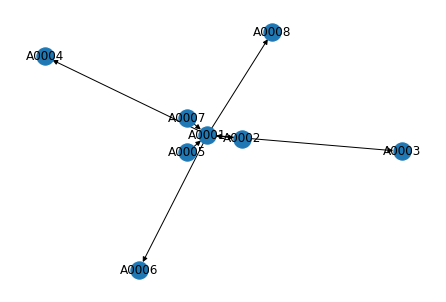

In [27]:
nx.draw(G, with_labels=True)
plt.show()

In [48]:
df_meta.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [ ]:
cols = ["adult", "genres", "title", "release_date", "revenue", "vote_count", "vote_average"]

In [51]:
df_meta["genres"][0]

"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]"

In [87]:
df_meta.iloc[2472]

adult                                                                False
belongs_to_collection                                                  NaN
budget                                                                   0
genres                   [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
homepage                                                               NaN
id                                                                   27455
imdb_id                                                          tt0166195
original_language                                                       en
original_title                                                     Foolish
overview                 'Foolish' Waise is a talented comedian with a ...
popularity                                                        0.431822
poster_path                               /2uOoAVhjKvKlI923SUnUkL7lO9H.jpg
production_companies     [{'name': 'No Limit Films', 'id': 16718}, {'na...
production_countries     

In [86]:
df_meta[df_meta["imdb_id"].str.slice(start=3).isin([""])]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
19730,- Written by Ørnås,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[{'name': 'Carousel Productions', 'id': 11176}...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",1997-08-20,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-09-29,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35587,Avalanche Sharks tells the story of a bikini ...,2.185485,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[{'name': 'Odyssey Media', 'id': 17161}, {'nam...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",2014-01-01,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
df_meta["imdbId"] = df_meta["imdb_id"].str.slice(start=3).astype(np.int)

ValueError: invalid literal for int() with base 10: ''

In [76]:
df_meta

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,imdbId


In [74]:
df_meta["imdbId"]

Series([], Name: imdbId, dtype: int32)

In [58]:
df_link.columns

Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')

In [59]:
df_link.loc[df_link["imdbId"] == 114709, :]

,movieId,imdbId,tmdbId
0,1,114709,862.0


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [60]:
df_link.loc[df_link["movieId"] == 31, :]

,movieId,imdbId,tmdbId
30,31,112792,9909.0


---

## production_companies 전처리 버리기 ..

In [371]:
def search_between_two(a, b, text):
    return re.findall(re.escape(a) + "(.*?)" + re.escape(b), text)

def change_string(x):
    matched = search_between_two(r'""', r'""', x)
    if matched:
        try:
            all_errors = defaultdict(list)
            for ms in matched:
                all_errors[ms].extend([i for i, s in enumerate(ms) if s == "'"])
            indices = [0]
            for ms, s_idxes in all_errors.items():
                indices.extend([x.index(ms) + s_idx for s_idx in s_idxes])
            indices += [len(x)]
            temp = []
            for i, j in zip(indices[:-1], indices[1:]):
                temp.append(x[i:j].lstrip(re.escape("'")))
            return " ".join(temp)
        except ValueError: # substring not found
            return x.replace('""', '')
    else:
        return x
# RULE_STR = r"\"\".*([\w]\'[\w]+)|([\w]\'[\s]+[\w]+).*\"\""
# find_parsing_error = lambda x: len(re.findall(r"([\w]\'[\w]+)|([\w]\'[\s]+[\w]+)", x)) > 0
# def change_string(x):
#     matched = []
#     for s in re.findall(r"([\w]\'[\w]+)|([\w]\'[\s]+[\w]+)", x):
#         matched.extend(ele for ele in s if ele)
#     indices = [0] + [x.index(s)+1 for s in matched] + [len(x)]
#     temp = []
#     for i, j in zip(indices[:-1], indices[1:]):
#         temp.append(x[i:j].lstrip("'"))
#     return "_".join(temp)

In [372]:
df_meta.loc[:, "production_companies"] = df_meta.loc[:, "production_companies"].apply(change_string).values
df_meta.loc[:, "production_companies"] = df_meta.loc[:, "production_companies"]\
    .str.replace('""Perspektywa', 'Perspektywa').str.replace('""', "\'").str.replace('"', '')

In [299]:
if matched:
    indices = [0] + [x.index(s)+s.index("'") for s in matched] + [len(x)]
    temp = []
    for i, j in zip(indices[:-1], indices[1:]):
        temp.append(x[i:j].lstrip(re.escape("'")))
    print(" ".join(temp))

In [274]:
x = df_meta.loc[idx, "production_companies"].iloc[7]

In [184]:
x = df_meta.loc[idx, "production_companies"].iloc[8]
x

'"[{\'name\': \'Stéphan Films\', \'id\': 2359}, {\'name\': ""Centre du Cinéma et de l\'Audiovisuel de la Fédération Wallonie-Bruxelles"", \'id\': 11796}, {\'name\': ""Sol\'oeil Films"", \'id\': 43860}, {\'name\': \'Lamy Films\', \'id\': 66451}, {\'name\': \'Ministère des Affaires étrangères et du Développement International\', \'id\': 72598}]"'

In [348]:
idx = df_meta["production_companies"].str.find("Ministerstvo kultury Rossiyskoy Federatsii") > 0 

In [350]:
x = df_meta.loc[idx, "production_companies"].iloc[0]
x

'"[{\'name\': \'Channel One Russia\', \'id\': 1039}, {\'name\': \'KoBura Film\', \'id\': 5283}, {\'name\': \'Ministerstvo kultury Rossiyskoy Federatsii\', \'id\': 25125}, {\'name\': ""Studiya dokumental\'nykh fil\'mov Sankt-Peterburga"", \'id\': 25126}, {\'name\': \'Kinokompaniya Non-Stop Prodakshn\', \'id\': 41762}]"'

In [365]:
x = '"[{\'name\': \'Stéphan Films\', \'id\': 2359}, {\'name\': ""Centre du Cinéma et de l\'Audiovisuel de la Fédération Wallonie-Bruxelles"", \'id\': 11796}, {\'name\': ""Sol\'oeil Films"", \'id\': 43860}, {\'name\': \'Lamy Films\', \'id\': 66451}, {\'name\': \'Ministère des Affaires étrangères et du Développement International\', \'id\': 72598}]"'

In [366]:
search_between_two(r'""', r'""', x)

["Centre du Cinéma et de l'Audiovisuel de la Fédération Wallonie-Bruxelles",
 "Sol'oeil Films"]

In [367]:
change_string(x)

'"[{\'name\': \'Stéphan Films\', \'id\': 2359}, {\'name\': ""Centre du Cinéma et de l Audiovisuel de la Fédération Wallonie-Bruxelles"", \'id\': 11796}, {\'name\': ""Sol oeil Films"", \'id\': 43860}, {\'name\': \'Lamy Films\', \'id\': 66451}, {\'name\': \'Ministère des Affaires étrangères et du Développement International\', \'id\': 72598}]"'

In [368]:
matched = search_between_two(r'""', r'""', x)
if matched:
    all_errors = defaultdict(list)
    for ms in matched:
        all_errors[ms].extend([i for i, s in enumerate(ms) if s == "'"])
    indices = [0]
    for ms, s_idxes in all_errors.items():
        indices.extend([x.index(ms) + s_idx for s_idx in s_idxes])
    indices += [len(x)]
    temp = []
    for i, j in zip(indices[:-1], indices[1:]):
        temp.append(x[i:j].lstrip(re.escape("'")))

In [370]:
"_".join(temp)

'"[{\'name\': \'Stéphan Films\', \'id\': 2359}, {\'name\': ""Centre du Cinéma et de l_Audiovisuel de la Fédération Wallonie-Bruxelles"", \'id\': 11796}, {\'name\': ""Sol_oeil Films"", \'id\': 43860}, {\'name\': \'Lamy Films\', \'id\': 66451}, {\'name\': \'Ministère des Affaires étrangères et du Développement International\', \'id\': 72598}]"'

In [360]:
all_errors

[18, 27]

In [358]:
[for s in matched[0]]

["Studiya dokumental'nykh fil'mov Sankt-Peterburga"]

In [357]:
temp[1]

'nykh fil\'mov Sankt-Peterburga"", \'id\': 25126}, {\'name\': \'Kinokompaniya Non-Stop Prodakshn\', \'id\': 41762}]"'

In [306]:
f = lambda p_str: "|".join([tuple(dict(x).values())[0] for x in eval(p_str)])

In [93]:
x = change_string(x)
x

"[{'name': 'Stéphan Films', 'id': 2359}, {'name': 'Centre du Cinéma et de l [{'name': 'Stéphan Films', 'id': 2359}, {'name': 'Centre du Cinéma et de l_Audiovisuel de la Fédération Wallonie-Bruxelles', 'id': 11796}, {'name': 'Sol oeil Films', 'id': 43860}, {'name': 'Lamy Films', 'id': 66451}, {'name': 'Ministère des Affaires étrangères et du Développement International', 'id': 72598}]"

In [373]:
df_meta["production_companies"].apply(lambda p_str: "|".join([tuple(dict(x).values())[0] for x in eval(p_str)]))

SyntaxError: invalid syntax (<string>, line 1)

---